In [1]:
# SimpleWPGen_Strip
# Ren Cooper, LBNL
# Gamma-Ray Tracking School, ORNL, October 2018
#
# very simple Weighting Potential solver for a single strip of a HPGe detector via SOR method
#  - Disclaimer: for demonstration/example purposes only!
#
# also includes a very crude example of signal generation


In [2]:
%matplotlib inline
%reset -f

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# set some detector parameters
strip_width_mm = 2.8
strip_gap_mm = 0.2
detector_thickness_mm = 16.0
pixel_size_mm = 0.1

# set detector width to n*pitch where n is an odd number
detector_width_mm = (9*strip_width_mm+strip_gap_mm)

In [5]:
# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)

In [6]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

# strip surface
geom_map[:,-1] = 2

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,-1] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

In [7]:
# set boundary conditions 

# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 3)
V[ix,iy] = 0

# strip
[ix,iy] = np.where(geom_map == 1)
V[ix,iy] = 1

In [8]:
# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*V_local_sum - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

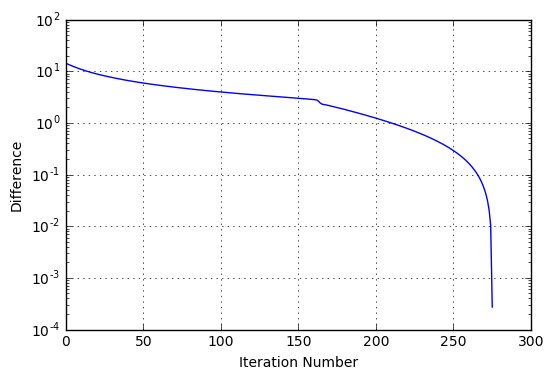

Final Difference:
0.000272582469532


In [9]:
# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

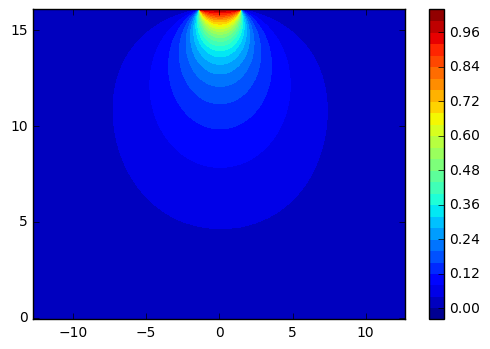

In [12]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

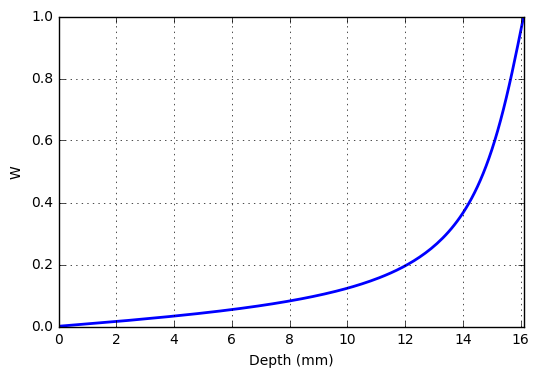

In [17]:
# take a slice through the WP
x_slice = 125
Vslice = V[x_slice,:]


plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
plt.xlim(0, 16.1)
plt.ylim(0, 1)
plt.show()


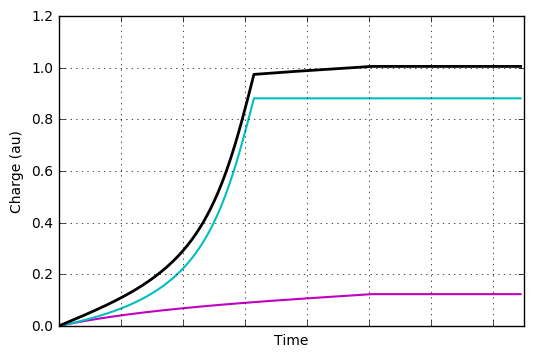

In [18]:
# simple signal calculation assuming fixed velocity of one pixel per ns for both electrons and holes
# holes into wp, electrons out
# could easily vectorize to be faster and more pythonic

# assume an interaction position at a given depth
depth_mm = 10

z0 = np.int(np.floor(depth_mm / pixel_size_mm))

# number of time steps in signal
Nt = 150

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh = z0
ze = z0

# holes into wp
t = 0
for t in range(1, Nt):
    if (zh<=N_yelements-1):
        dw = Vslice[zh] - Vslice[zh-1]
        Qh[t] = 1.0*dw    
    elif (zh>N_yelements-1):
        continue
    zh = zh+1

# electrons out of wp
t = 0
for t in range(1, Nt):
    if (ze>=0):
        dw = Vslice[ze] - Vslice[ze+1]
        Qe[t] = -1.0*dw
    elif (ze<0):
        continue
    ze = ze-1

# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

# plot
plt.plot(Qsignal_e, 'm', linewidth=1.5)
plt.plot(Qsignal_h, 'c', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)
plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()